# Puffer Replay

You use this notebook to explore the Puffer data replay results and/or recreate the following figures:

**Main paper:**
- Figure 2
- Figure 5
- Figure 7
- Figure 8
- Figure 9

**Appendix:**
- Figure 21
- Figure 22
- Figure 23
- Figure 24
- Figure 25

For a simpler overview of the evaluation data, see the [demo notebook](demo.ipynb).

## Prerequisites

You must download and evaluate the puffer data, which you can do by running the following CLI commands:

```bash
./run.py puffer-download

# Optional, but strongly recommended to reduce data loading times.
./run.py puffer-preprocess

./run.py puffer-replay
```

_Warning_: The full dataset including pre-processed files is about 1TB large and the download and preprocessing may take several hours.
Preprocessing the data takes about 3 minutes per day (can be parallelized) and prepares the Puffer "TTP" model input/output from the dataset. If you do not preprocess the data, this step is done on the fly for every experiment.
As each replay experiment accesses the data of each day, this adds considerable computational and time overhead, so we recommend preprocessing if you can spare the disk space.

Running the replay experiments takes several hours per experiment (when using a GPU, even longer otherwise). This is due to the nature of continual learning over long periods of time: we need to evaluate how memory is updated over time, and thus need to process all days sequentially. This includes re-training the ML models multiple times, and each training may take up to an hour on a single GPU.

To increase confidence in our results, every experiment is run three times with data from different periods of time. See [experiments/puffer/experiments.py](../experiments/puffer/experiments.py) for the experiment defintions.

You can use `-l` to list all experiments and use glob pattern matching to run only some experiments. For example:

```bash
# List all experiments
./run.py puffer-replay -l
# Run all experiments with only the data period (2021-01-01 to 2021-07-01)
./run.py puffer-replay "*/2021-01-01_2021-07-01"
# Run a specific experiment (with all periods or just one)
./run.py puffer-replay comparison/bandwidth/0.1
./run.py puffer-replay comparison/bandwidth/0.1/2021-07-01_2022-01-01
```

See `REAMDE.md` for additional CLI options such as verbosity, running experiments in parallel, or scheduling jobs with Slurm.

## Imports and Settings

In [1]:
import sys
sys.path.append('..')  # To allow imports from parent directory
%load_ext autoreload
%autoreload 2

In [2]:
import experiment_helpers as eh
import numpy as np
import pandas as pd
import seaborn as sns
from experiment_helpers.data import Path
from matplotlib import pyplot as plt

# Load the config, including the local config.
from config import Config as LocalConfig  # File: ../config.py
from experiments.puffer.config import PufferExperimentConfig

config = PufferExperimentConfig.with_updates(LocalConfig)
resultdir = config.output_directory / "puffer-replay"

In [3]:
# Plot import and configuration.
%matplotlib inline

# Set theme and parameters
eh.plot_utils.setup(latex=True)

plotdir = Path("../plots/puffer-replay")
plotdir.mkdir(exist_ok=True, parents=True)

## Data helpers

We collect a lot of metrics across many experiments. Here, we define helpers to load and combine multiple experiments into a single frame and select he metrics we are going to plot.

Finally, to simplify the plots, we are not going to plot the indivdual logscores, but rather the difference between Memento and Fugu.

In [4]:

# Utilities to plot comparison per run for the main paper.
# ========================================================

default_metrics = {
    '0.5': "Median",
    '0.01': "1st P.",
}
default_metric_order = ["Median", "1st P."]
default_metric_order_fullname = ["Median", "1st Percentile"]

# Data loading utilities.
# =======================

def load_data(experiments,
              resultdir=resultdir,
              file='results.csv.gz',
              metrics=default_metrics):
    """Load results from deployment comparison.

    Importantly, the files are names run_comparison-date.

    Experiments should be a dict of paths, concretely subpahts of resultdir,
    and a label that will be used to identify this experiment.
    """
    frames = []
    for experiment_subpath, name  in experiments.items():
        # Check if there are multiple runs.
        _paths = list((resultdir / experiment_subpath).iterdir())
        if all(subpath.is_dir() for subpath in _paths):
            run_paths = _paths
        else:
            run_paths = [resultdir / experiment_subpath]

        for run_path in run_paths:
            try:
                frame = eh.data.read_csv(run_path / file)

                # Typo in some old experiments, fix it when loading.
                # Also update file so it's fixed.
                if 'coverage_increage' in frame:
                    frame = frame.rename(
                        columns={'coverage_increage': "coverage_increase"})
                    eh.data.read_csv(frame, run_path / file)

            except FileNotFoundError:
                print(f"No results for {name}! ({run_path / file})")
                continue

            # Filter metrics for plotting.
            if 'metric' in frame:
                if metrics:
                    frame = frame[lambda df: df['metric'].isin(metrics)]
                frame = frame.astype({"metric": "category"})
                if isinstance(metrics, dict):
                    frame = frame.assign(metric=frame['metric'].map(metrics))

            # From the raw logscores, compute advantage for nicer plotting.
            if 'logscore' in frame:
                frame = (
                    frame
                    .assign(
                        advantage=frame['logscore']-frame['fugu_logscore'],
                        advantage_feb=(
                            frame['logscore']-frame['fugu_feb_logscore'])
                    )
                )


            # Add metadata
            frame = frame.assign(
                experiment=name,
                experiment_path=experiment_subpath,
                run=run_path.name,
            )
            frames.append(frame)

    return pd.concat(frames, axis=0, ignore_index=True)

def load(experiments, resultdir=resultdir, metrics=default_metrics):
    """Load results and stats."""
    return (
        load_data(experiments, resultdir=resultdir, file='results.csv.gz',
                  metrics=metrics),
        load_data(experiments, resultdir=resultdir, file='stats.csv.gz')
    )

## Plot Helpers

We have a lot of different comparison which are all plotted in the same way; let's define helpers for both aggregate plots (main paper) and detailed timeseries (appendix).

In [5]:
# We plot the advantage (difference in logscore) compared to retraining with
# random samples.
comparison = "advantage"
# comparison = "advantage_feb"  # Compare to Fugu (static), i.e. no retraining.

# Utility to summarize results.
# =============================

def summarize(results, *extra_groups, comp=comparison, skip=21):
    return (
        results
        #.query("iteration > @skip")
        .groupby(["metric",  *extra_groups, "experiment"])
        [comp]
        .mean()
        .unstack()
    )


# Utilities to plot the tail loss timeseries only for the intro and core.
# ========================================================================


def plot_tail(results, y="loss", ylabel="99th Percentile Loss",
              rolling=14,
              axis_stepsize=21, quick_ci=False, ylim=None, opts=None,
              arrow_loc=(0.038, 0.1), arrow_rot=-90,
              legend_loc="lower right",  legend_kwargs={}):
    """Plot first perctentile score * -1, which is the 99th percentile loss.

    The score is logscore, which is the negative crossentropy, which is the
    loss used in Puffer.
    """
    last_iter = results['iteration'].max()
    ticks = np.arange(axis_stepsize, last_iter, axis_stepsize)
    ticklabels = ticks // 7  # #Weeks instead of #Days.

    extra = {'n_boot': 10} if quick_ci else {}
    if opts is None:
        opts = eh.plot_utils.opts_short(facet_kws=dict(legend_out=False))

    frame = (
        sns_rolling(results, rolling)
        .query("metric == '1st P.'")
        .assign(loss=lambda df: -df['logscore'])
    )

    grid = sns.relplot(
        data=frame,
        kind="line",
        x="iteration",
        y=y,
        style='experiment',
        hue='experiment',
        estimator=np.mean,
        errorbar=('ci', 90),
        **opts, **extra,
    ).set(
        title=None,
        xlabel="Weeks of Puffer data replayed",
        ylabel=ylabel,
        ylim=ylim,
        xticks=ticks, xticklabels=ticklabels,
    )

    # Legend tweaks.
    legend_opts = dict(title=None, handlelength=1.25, handletextpad=0.5)
    if legend_kwargs:
        legend_opts.update(legend_kwargs)
    sns.move_legend(plt.gca(), legend_loc, **legend_opts)

    # Add a little arrow labeled "better".
    plt.gca().text(
        *arrow_loc, "better", transform=plt.gca().transAxes,
        ha="left", va="bottom", rotation=arrow_rot, size=15,
        bbox=dict(boxstyle="rarrow,pad=0.2", fc="lightgray", ec="gray", lw=1))

    return grid


# Utilities to plot per-run median for the main paper.
# ====================================================

def plot_average(results, title="experiment",
                 extra_groups=[], # skip=21,
                 hue=None, hue_order=None,
                 style=None, style_order=None,
                 plot_opts=eh.plot_utils.opts_onethird,
                 plot_kwargs=None, **ax_args):
    """Plot average per run for a given grouping."""
    if hue is None:
        hue = "metric"
        if hue_order is None:
            hue_order = default_metric_order
    if style is None:
        style = "metric"
        if style_order is None:
            style_order = default_metric_order
    if plot_kwargs is None:
        plot_kwargs = {}
    if extra_groups is None:
        extra_groups = []

    grid = sns.relplot(
        kind='scatter',
        data=(
            results
            #.query("iteration > @skip")
            .groupby(
                ["experiment", "metric", "run", *extra_groups],
                as_index=False
            )
            .mean(numeric_only=True)
        ),
        x="experiment",
        y=comparison,
        **plot_opts(**{
            "hue": hue,
            "style": style,
            "hue_order": hue_order,
            "style_order": style_order,
            **plot_kwargs,
        })
    ).set(
        xlabel=title,
        ylabel='Logscore Improvement',
        ylim=(-0.5, 1.25),
        **ax_args,
    )

    ax = plt.gca()
    if not plot_kwargs.get("facet_kws", {}).get("legend_out"):
        # Remove legend title
        ax.legend(title=None)

    # Highlight 0
    xlim = ax.get_xlim()
    ax.plot(xlim, [0,0], "-", zorder=0, color="darkgray", linewidth=2)
    ax.set_xlim(xlim)

    return grid


# Utitlities to plot the full time series for the appendix.
# =========================================================

def plot_timeseries(results, title="experiment", rolling=14, y=comparison,
                    style=None, style_order=None,
                    metric="metric", metric_order=default_metric_order,
                    axis_stepsize=21, quick_ci=False, ylim=(-0.5, 1.25),
                    opts=None):
    """"Plot the full timeseries, rolling median over (default) 14 days.

    Use quick_ci=True for a quick and dirty CI that takes less time.
    """
    last_iter = results['iteration'].max()
    ticks = np.arange(axis_stepsize, last_iter, axis_stepsize)
    ticklabels = ticks // 7  # #Weeks instead of #Days.

    extra = {'n_boot': 10} if quick_ci else {}
    if opts is None:
        opts = eh.plot_utils.opts(facet_kws=dict(legend_out=True))

    grid = sns.relplot(
        kind='line',
        data=sns_rolling(
            results.rename(columns={'experiment': title}),
            14
        ),
        x="iteration",
        y=y,
        hue=title,
        palette="deep",  # Use discrete colors, not a gradient.
        col=metric, col_order=metric_order,
        estimator=np.mean,
        errorbar=('ci', 90),
        **extra,
        **opts,
        legend=True,
        style=style,
        style_order=style_order,
    ).set(
        title=None,
        xlim=(0, last_iter),
        xticks=ticks,
        xticklabels=ticklabels,
        xlabel="Weeks replayed",
        ylim=ylim,
        ylabel="Logscore Improvement",
    )

    fig = plt.gcf()
    for ax, name in zip(fig.axes, default_metric_order_fullname):
        ax.set_title(name)

        # Also highlight x=0
        xlim = ax.get_xlim()
        ax.plot(xlim, [0,0], "-", zorder=0, color="darkgray", linewidth=2)
        ax.set_xlim(xlim)

    return grid


def sns_rolling(frame, iterations):
    """Prepare a frame so plotting with seaborn leads to a rolling result.

    Concretely, copy the frame and increase the day, so that in the end a given
    day contains data from the past `iteration` frames.

    Better for seaborn CI than smooth.
    """
    x_col = frame['iteration']
    last_x = x_col.max()
    copies = [frame.assign(iteration=x_col + ind)
              for ind in range(iterations)]
    # Merge and remove days shifted into the future.
    return (
        pd
        .concat(copies)
        [lambda df: df['iteration'] <= last_x]
        .reset_index(drop=True)
    )


# Data overview

Check how much data is used per run, i.e. per period of data. Both in terms of stream years and in the number of chunks.

In [6]:
SECONDS_PER_YEAR = 31556952
overview = load_data({
    "stats": "stats",
}).assign(
    stream_years=lambda df: df['stream_seconds'] / SECONDS_PER_YEAR
).sort_values(by="day")

print("Stream-years per day (quantiles):")
display(overview['stream_years'].quantile([0.1, 0.5, 0.9, 1]))
print("Mean stream-years per day:")
display(overview['stream_years'].mean())

print("Stream-years per data period:")
display(
    overview
    .groupby("run")
    ["stream_years"]
    .sum()
)

print("Total stream-years:")
display(overview['stream_years'].sum())

Stream-years per day (quantiles):


0.1    0.079071
0.5    0.147641
0.9    0.373019
1.0    0.763955
Name: stream_years, dtype: float64

Mean stream-years per day:


0.192526339976428

Stream-years per data period:


run
2021-01-01_2021-07-01    25.543124
2021-07-01_2022-01-01    42.787763
2022-01-01_2022-06-01    30.050073
Name: stream_years, dtype: float64

Total stream-years:


98.38095972795472

In [7]:
SECONDS_PER_YEAR = 31556952
overview = load_data({
    "stats": "stats",
}).assign(chunks=lambda df: df['chunks'] / 1e6).sort_values(by="day")

print("Million chunks per day (quantiles):")
display(overview['chunks'].quantile([0.1, 0.5, 0.9, 1]))
print("Million chunks per day (mean):")
display(overview['chunks'].mean())

print("Million chunks per run")
display(
    overview
    .groupby("run")
    ["chunks"]
    .sum()
)

print("Million chunks, total:")
display(overview['chunks'].sum())

Million chunks per day (quantiles):


0.1     1.246994
0.5     2.328378
0.9     5.882733
1.0    12.048022
Name: chunks, dtype: float64

Million chunks per day (mean):


3.0362541076320944

Million chunks per run


run
2021-01-01_2021-07-01    402.830152
2021-07-01_2022-01-01    674.788300
2022-01-01_2022-06-01    473.907397
Name: chunks, dtype: float64

Million chunks, total:


1551.525849

# Figure 22: Comparison to random memories (of same and double size) and Euclidean distance

Default settings and random memory, and also a random memory with double the size.
We can see that simply making more space in the memory helps little if we do not improve the sample selection.
Also include using Euclidean distance instead of the JSD distribution distance, which (as we can see) does not significantly improve the results compared to a random selection, as not using distributions `swallows' the rare values. 

experiment,Memento,Memento (Euclidean),Random,Random (2x mem)
metric,,,,
1st P.,0.703961,-0.090847,0.013827,0.046614
Median,-0.169341,0.001123,-0.003088,-0.002917


experiment,Memento,Memento (Euclidean),Random,Random (2x mem)
metric,,,,
1st P.,0.920023,0.122165,0.229890,0.262677
Median,-0.158190,0.012558,0.008063,0.008235


/tmp/ipykernel_15554/422612744.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


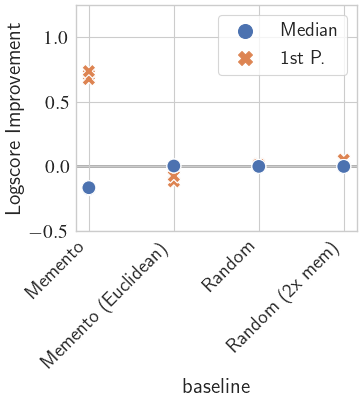

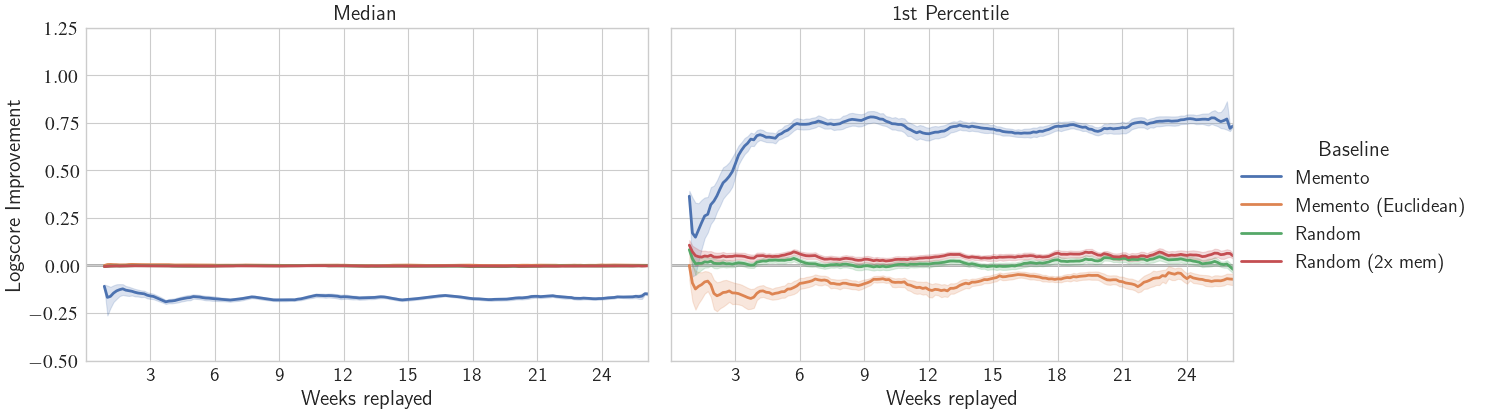

In [47]:
baseline_results, baseline_stats = load({
    'comparison/baseline/default': 'Memento',
    'comparison/euclidean': 'Memento (Euclidean)',
    'comparison/baseline/random': 'Random',
    'comparison/memsize/double': 'Random (2x mem)',
})
display(summarize(baseline_results))
display(summarize(baseline_results, comp="advantage_feb"))
plot_average(baseline_results, title="baseline")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

plot_timeseries(baseline_results, title="Baseline")
plt.gcf().savefig(plotdir / "baseline_timeline.pdf")
plt.show()


# Figure 2: More is not always better

Also include Query-By-Comittee (QBC), for "more models".
And the increased size for "more data".

First all the data, then a subset to focus on the concrete point.

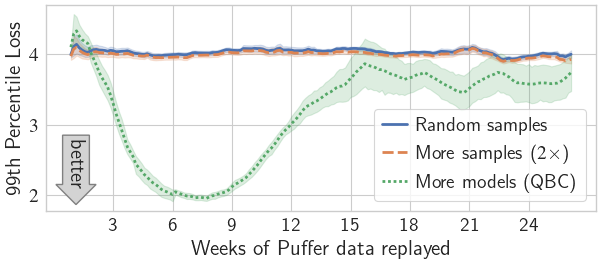

In [8]:
# Alternative, try loss (just the negative logscore).
qbc_intro_results, qbc_intro_stats = load({
    'comparison/baseline/random': 'Random samples',
    'comparison/memsize/double': 'More samples ($2\\times$)',
    #'combinations/qbc': 'Models',
    'combinations/qbc-matchmaker': 'More models (QBC)',  # Oracle only
})

plot_tail(qbc_intro_results)
plt.gcf().savefig(plotdir / "intro_loss.pdf")
plt.show()

# Figure 5: Euclidan Distance vs JSD

The euclidean distance between batch averages fails to pick up on tail patterns, while the JSD between batch distribution does.

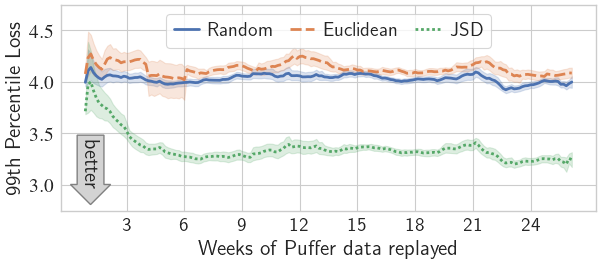

In [ ]:
euclidean_results, euclidean_stats = load({
    'comparison/baseline/random': 'Random',
    'comparison/euclidean': 'Euclidean',
    'comparison/baseline/default': 'JSD',
})

plot_tail(euclidean_results,
          ylim=(2.75, 4.75),
          legend_loc="upper center",
          legend_kwargs={"ncol": 3, "columnspacing": 0.8})
plt.gcf().savefig(plotdir / "euclidean_tail_loss.pdf")
plt.show()

# Figure 7a and 23a: Batching size

Larger batches make Memento more computationally efficient at the cose of granularity.

In [ ]:
bsizes = [128, 256, 512, 1024, 2048]
bsize_results, bsize_stats = load({
    f'comparison/batchsize/{bsize}': bsize
    for bsize in bsizes
})
summarize(bsize_results)

experiment,128,256,512,1024,2048
metric,,,,,
1st P.,0.760648,0.704389,0.643829,0.611687,0.612789
Median,-0.163284,-0.169262,-0.158993,-0.144208,-0.129253


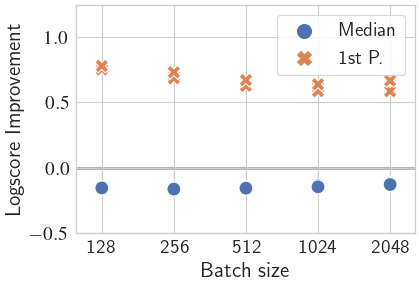

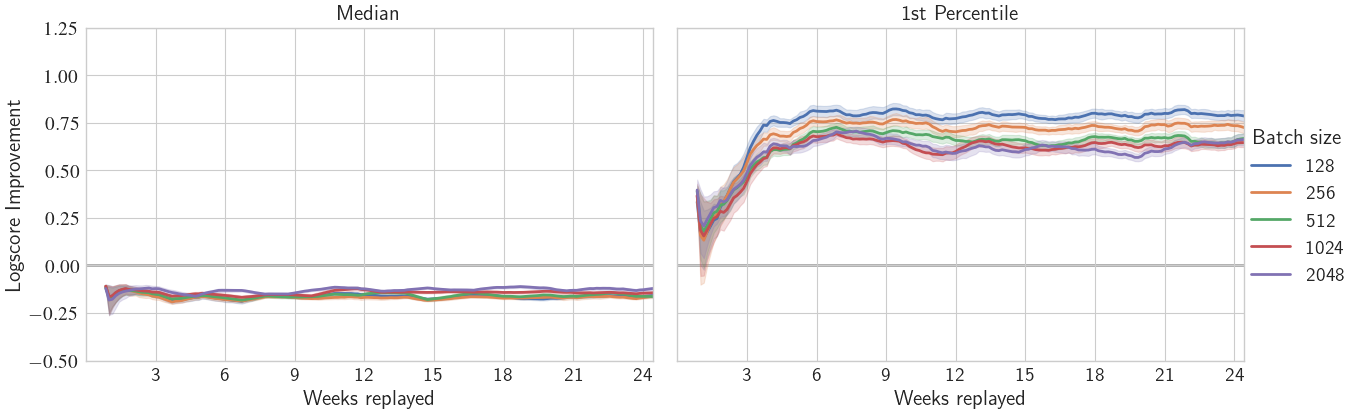

In [ ]:
plot_average(
    bsize_results,
    title="Batch size",
    # Log axis.
    xscale='log',
    xlim=(100, 2600),
    xticks=bsizes,
    xticklabels=bsizes,
)
plt.gcf().savefig(plotdir / 'batchsize.pdf')
plt.show()

plot_timeseries(bsize_results, title="Batch size")
plt.savefig(plotdir / "batchsize_timeline.pdf")
plt.show()

## Computation Time

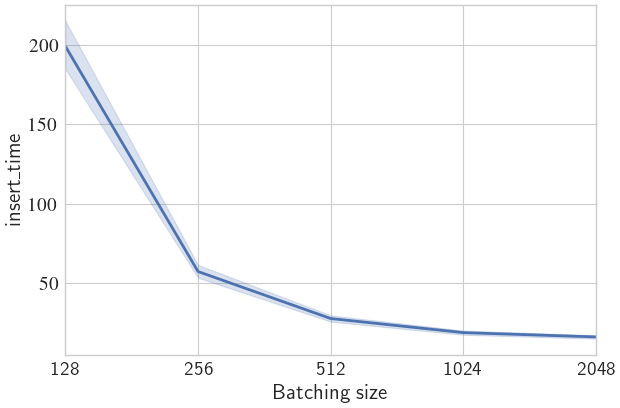

In [ ]:
sns.relplot(
    kind='line',
    data=bsize_stats,  #[lambda df: df['iteration'] > 60],
    x="experiment",
    y="insert_time",
    **eh.plot_utils.default_opts,
).set(
    xscale='log',
    xlim=(np.min(bsizes), np.max(bsizes)),
    xticks=bsizes,
    xticklabels=bsizes,
    xlabel="Batching size",
);

In [ ]:
memsize = 1000000
(
    bsize_stats
    .assign(nbatches=lambda df: memsize // df['experiment'])
    .dropna(subset=['insert_time'])
    .groupby(['experiment', 'nbatches'])
    [["insert_time"]]
    .agg(["count", "mean", "std"])
)

insert_time                        
                          count        mean         std
experiment nbatches                                    
128        7812             358  199.212263  152.463880
256        3906             423   57.182681   42.818733
512        1953             416   27.552579   20.444237
1024       976              437   18.671208   14.000119
2048       488              444   15.965727   11.876037

# Figure 7b and 23b: Density estimation bandwidth

By default, Memento estimates density from distances by applying a Gaussian kernel that determines how small a distance needs to be to be relevant for density. It has a bandwidth parameter that determines the width of the Kernel, i.e. how much far away samples still have an impact.

In [ ]:
bws = [0.001, 0.01, 0.05, 0.08, 0.1, 0.125, 0.2, 0.5, 1, 10]
bw_results, bw_stats = load({
    f'comparison/bandwidth/{bw:g}': bw
    for bw in bws
})
summarize(bw_results)

experiment,0.001,0.010,0.050,0.080,0.100,0.125,0.200,0.500,1.000,10.000
metric,,,,,,,,,,
1st P.,-0.053958,0.197815,0.539740,0.656231,0.702016,0.712535,0.478361,0.138549,0.311401,-0.045243
Median,-0.007609,-0.044666,-0.133692,-0.166228,-0.169632,-0.172215,-0.178137,-0.153218,-0.097523,-0.003290


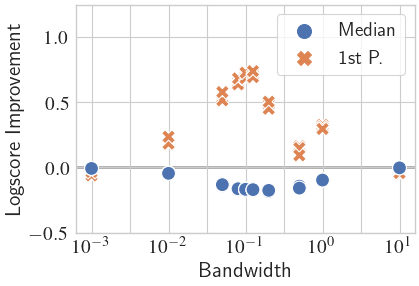

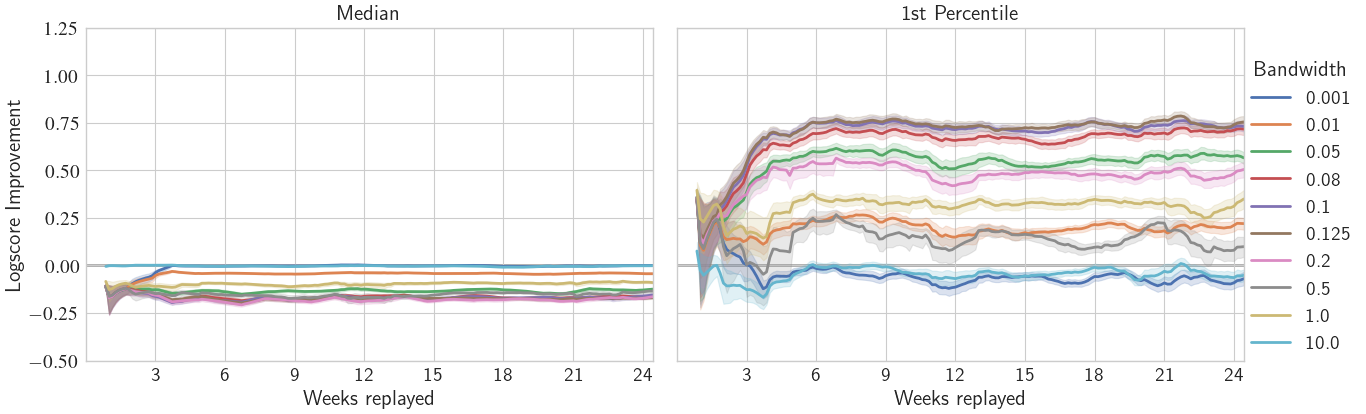

In [ ]:
plot_average(
    bw_results,
    title="Bandwidth",
    # Log axis.
    xscale='log',
    xticks=np.logspace(-3, 1, 9, base=10),
)
plt.gcf().savefig(plotdir / 'bandwidth.pdf')
plt.show()

plot_timeseries(bw_results, title="Bandwidth")
plt.savefig(plotdir / "bandwidth_timeline.pdf")
plt.show()

# Figure 7c and 23c: Temperatures

A higher temperatur means that the memory is more random, a lower temperature means its more deterministic.

In [ ]:
temps = [1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1, 1e1, 1e2]
temp_results, temp_stats = load({
    f'comparison/temperature/{temp:.0e}': temp
    for temp in temps
})
summarize(temp_results)

experiment,0.00001,0.00010,0.00100,0.00500,0.01000,0.05000,0.10000,1.00000,10.00000,100.00000
metric,,,,,,,,,,
1st P.,0.536742,0.637585,0.704389,0.749728,0.699226,0.387070,0.251566,-0.034171,-0.07287,-0.093872
Median,-0.398062,-0.429592,-0.335901,-0.225395,-0.170526,-0.066474,-0.039702,-0.004931,-0.00155,-0.000244


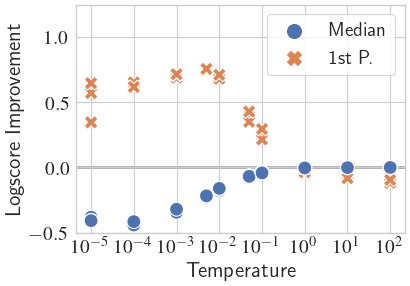

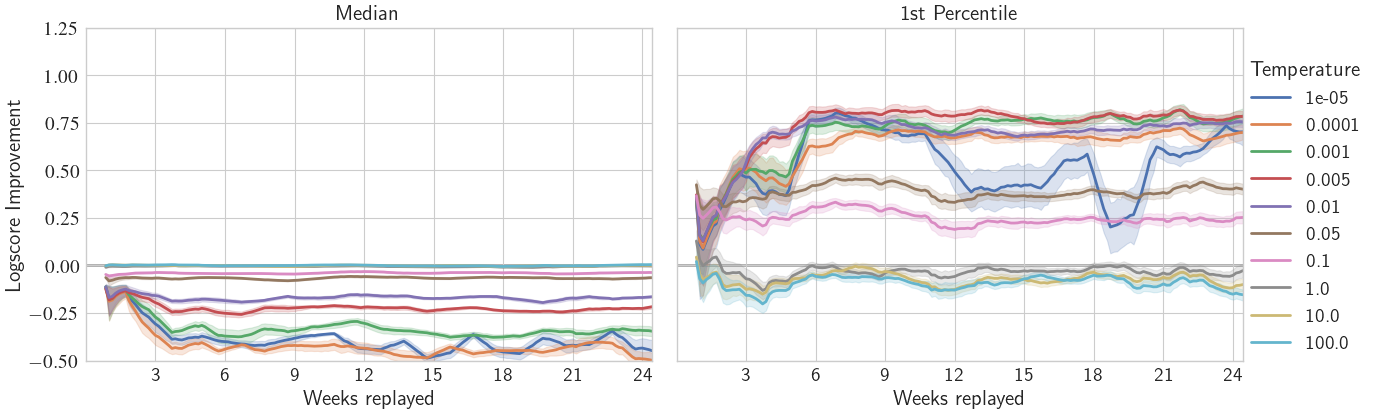

In [ ]:
plot_average(
    temp_results,
    title="Temperature",
    # Log axis.
    xscale='log',
    xticks=[10**i for i in range(-5, 3)],
)

plt.gcf().savefig(plotdir / 'temperature.pdf')
plt.show()

plot_timeseries(temp_results, title="Temperature")
plt.savefig(plotdir / "temperature_timeline.pdf")
plt.show()

## Figure 8 and 24a: Alternative metric: Loss

Alternative decision metricss instead of density.
We keep both batching and probabilistic selection with temperature such that the algorithms only differ in the metric.

In [ ]:
metric_loss, _ = load({
    f'comparison/metric/loss/{temp:.0e}': temp
    for temp in [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
})
summarize(metric_loss)

experiment,0.0001,0.0010,0.0100,0.1000,1.0000,10.0000,100.0000,1000.0000
metric,,,,,,,,
1st P.,-21.934490,-21.294473,-23.947571,-21.603750,-11.043105,0.402347,-0.007897,-0.062235
Median,-7.459094,-7.255801,-8.241033,-7.106805,-4.466757,-0.033457,-0.002399,0.000422


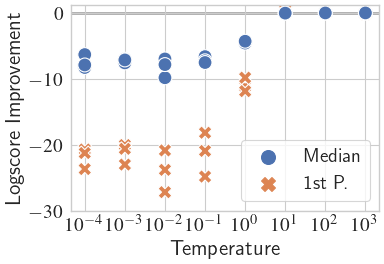

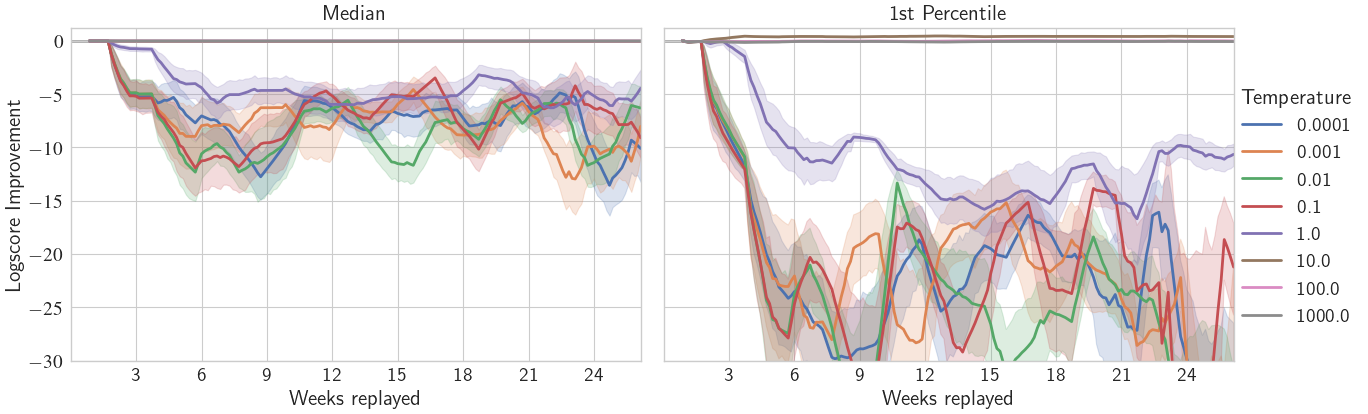

In [ ]:
plot_average(
    metric_loss,
    title="Temperature",
    # Log axis.
    xscale='log',
    xticks=[1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    plot_kwargs=dict(height=eh.plot_utils.default_height / 1.5)
).set(
    ylim=(-30, 1.25)
)
plt.gca().legend(loc='lower right')
plt.gcf().savefig(plotdir / 'alt_loss.pdf')
plt.show()

plot_timeseries(metric_loss, title="Temperature").set(
    ylim=(-30, 1.25)
)
plt.savefig(plotdir / "alt_loss_timeline.pdf")
plt.show()

# Figura 21a and 24b: Alternative metric: Confidence

Where confidence is defined as the probability of the predicted class/transmission bin. A high confidence means that the model puts (close to) all probability in one bin.

In [ ]:
metric_confidence, _ = load({
    f'comparison/metric/confidence/{temp:.0e}': temp
    for temp in [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
})
summarize(metric_confidence)

experiment,0.0001,0.0010,0.0100,0.1000,1.0000,10.0000
metric,,,,,,
1st P.,-1.682301,-0.800943,-1.052675,0.195441,-0.048834,-0.066570
Median,-0.865024,-0.691538,-0.767746,-0.124152,0.000701,0.000995


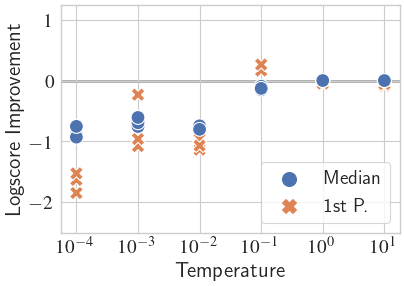

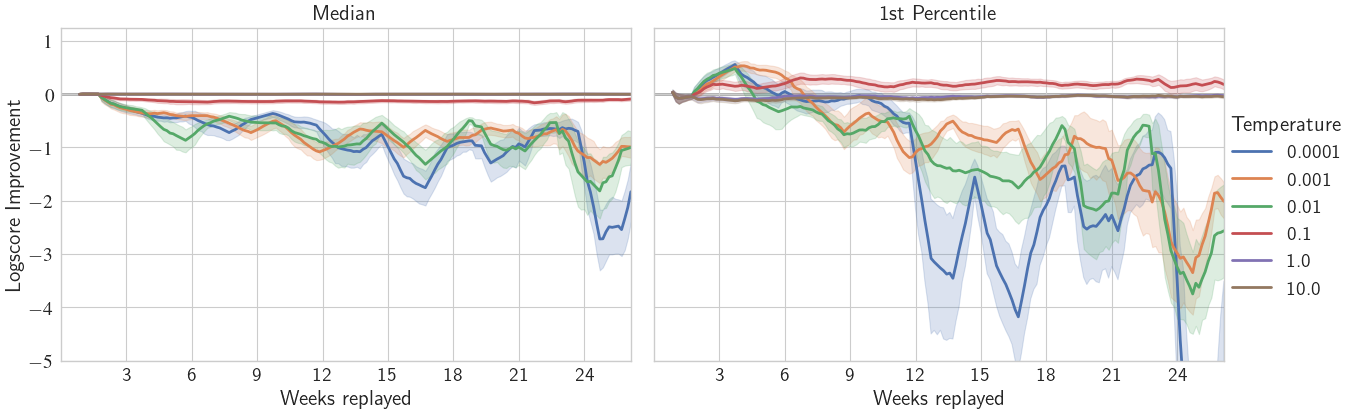

In [ ]:
plot_average(
    metric_confidence,
    title="Temperature",
    # Log axis.
    xscale='log',
    xticks=[1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],
).set(
    ylim=(-2.5, 1.25)
)
plt.gca().legend(loc='lower right')
plt.gcf().savefig(plotdir / 'alt_confidence.pdf')
plt.show()

plot_timeseries(metric_confidence, title="Temperature").set(
    ylim=(-5, 1.25)
)
plt.savefig(plotdir / "alt_confidence_timeline.pdf")
plt.show()

# Figura 21b and 24c: Alternative metric: Label/Class counts

Continual learning memories for classification problems often use a simplified version of density: counting the number of samples per class label. We find that this is too coarse grained in our setting with relatively few prediction bins ("classes") for very diverse samples.

In [ ]:
metric_counts, _ = load({
    f'comparison/metric/classcounts/{temp:.0e}': temp
    for temp in [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
})
summarize(metric_counts)

experiment,0.0001,0.0010,0.0100,0.1000,1.0000,10.0000
metric,,,,,,
1st P.,-15.445888,-15.412962,-15.422676,-3.201701,0.149693,-0.043309
Median,-11.713955,-11.517053,-11.566376,-2.221591,-0.021149,-0.001054


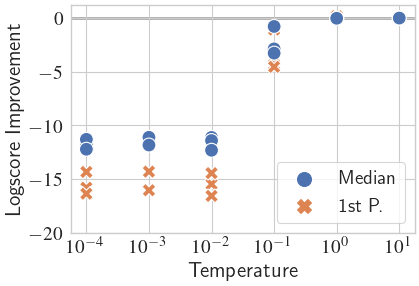

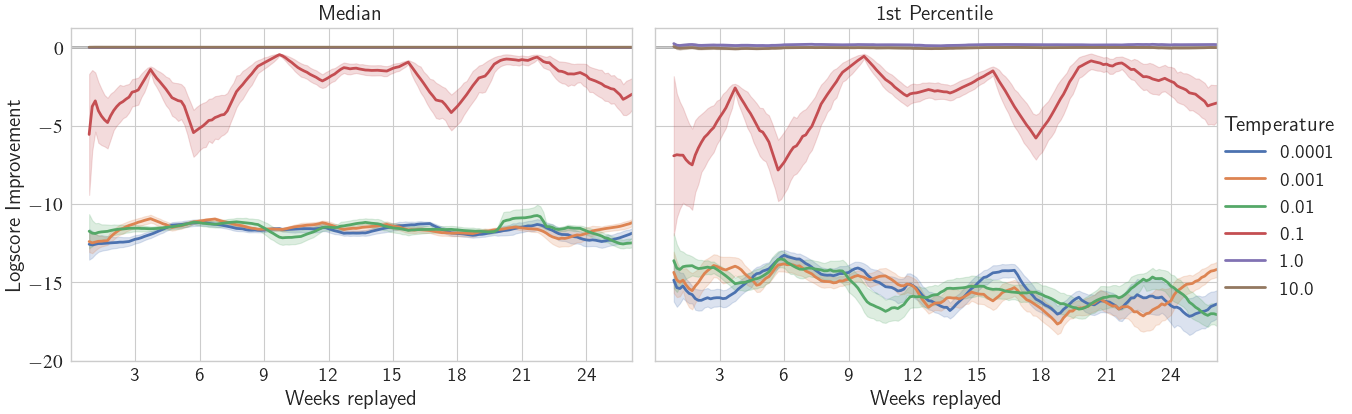

In [ ]:
plot_average(
    metric_counts,
    title="Temperature",
    # Log axis.
    xscale='log',
    xticks=[1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],
).set(
    ylim=(-20, 1.25)
)
plt.gcf().savefig(plotdir / 'alt_counts.pdf')
plt.show()

plot_timeseries(metric_counts, title="Temperature").set(
    ylim=(-20, 1.25)
)
plt.savefig(plotdir / "alt_counts_timeline.pdf")
plt.show()

# Figura 21c and 24d: Alternative metric: Stalls

What if we instead turn to video streaming metadata to make our decision? Here we decide whether to keep samples based on whether a session experienced stalls or not. We find this metric too be too coarse-grained to be efficient.

In [ ]:
metric_stalls, _ = load({
    f'comparison/metric/stalls/{temp:.0e}': temp
    # TODO: Check what's wrong with the algorithm for lower temps.
    for temp in [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
    #for temp in [1e-1, 1, 1e1]
})
summarize(metric_stalls)

experiment,0.0001,0.0010,0.0100,0.1000,1.0000,10.0000
metric,,,,,,
1st P.,0.003228,0.001954,0.013837,0.019796,-0.032715,-0.067817
Median,-0.006903,-0.006707,-0.008956,-0.010353,-0.000981,0.000309


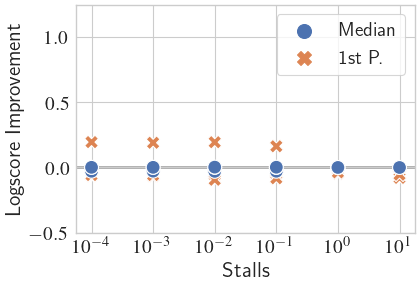

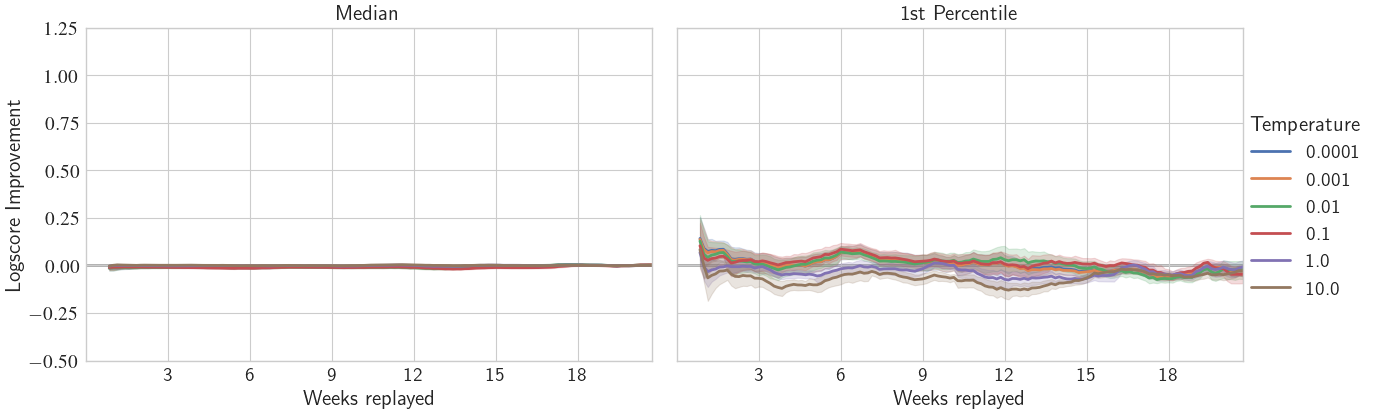

In [ ]:
plot_average(
    metric_stalls,
    title="Stalls",
    # Log axis.
    xscale='log',
    xticks=[1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],
)
plt.gcf().savefig(plotdir / 'alt_stalls.pdf')
plt.show()

plot_timeseries(metric_stalls, title="Temperature")
plt.savefig(plotdir / "alt_stalls_timeline.pdf")
plt.show()

# Figure 9 and 25: Combining Memento with JTT/Matchmaker.

JTT improves training, and Matchmaker predictions, while Memento improves sample selections. Here we show how they can profit from each other.

In [6]:
upscale_range = [2., 5., 10., 20., 50., 100.]

jtt_comparison = pd.concat([
    load_data({
        'comparison/baseline/random': 1,
        **{
            f'combinations/jtt/{upscale:g}': upscale
            for upscale in upscale_range
        }
    }).assign(comp="JTT"),
    load_data({
        'comparison/baseline/default': 1,
        **{
            f'combinations/memento-jtt/{upscale:g}': upscale
            for upscale in upscale_range
        }
    }).assign(comp="with Memento"),
    load_data({
        'combinations/memento-matchmaker': 1,
        **{
            f'combinations/memento-matchmaker-jtt/{upscale:g}': upscale
            for upscale in upscale_range
            if upscale != 3
        }
    }).assign(comp="and Matchmaker"),
])
summarize(jtt_comparison, "comp")

experiment                1.0       2.0       5.0       10.0      20.0   \
metric comp                                                               
1st P. JTT             0.013827  0.483586  0.967742  1.156392  1.228788   
       and Matchmaker  1.335225  1.582359  1.644539  1.704211  1.608756   
       with Memento    0.703961  1.000692  1.215909  1.278276  1.285808   
Median JTT            -0.003088 -0.059914 -0.215733 -0.398206 -0.571629   
       and Matchmaker -0.078932 -0.172486 -0.367284 -0.500239 -0.672713   
       with Memento   -0.169341 -0.313817 -0.529492 -0.681372 -0.841981   

experiment                50.0      100.0  
metric comp                                
1st P. JTT             1.227230  1.114115  
       and Matchmaker  1.504451  1.376562  
       with Memento    1.189751  1.049965  
Median JTT            -0.840366 -1.079573  
       and Matchmaker -0.941818 -1.114666  
       with Memento   -1.093638 -1.273298

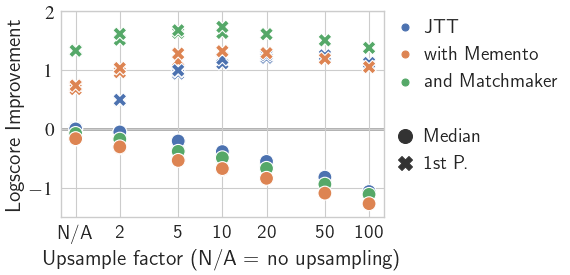

In [7]:
plot_upscale_range = [1, *[int(param) for param in upscale_range]]
plot_upscale_labels = ["N/A", *[int(param) for param in upscale_range]]
plot_average(
    jtt_comparison,
    extra_groups=["comp"],
    title="Upsample factor (N/A = no upsampling)",
    hue="comp", hue_order=["JTT", "with Memento", "and Matchmaker"],
    #plot_kwargs=dict(legend=False),
    xscale='log',
    xticks=plot_upscale_range,
    xticklabels=plot_upscale_labels,
    #plot_opts=plot_utils.opts_short,
    plot_kwargs=(dict(height=eh.plot_utils.default_height / 1.5))
).set(
    ylim=(-1.5, 2)
)

ax = plt.gca()
h, l = ax.get_legend_handles_labels()

# Remove the "comp" label.
h, l = h[1:], l[1:]

# Replace the "metric" label with empty string.
l = ["" if _l == "metric" else _l for _l in l]

plt.gca().legend(
    bbox_to_anchor=(0.95, 1.05), loc="upper left",
    #loc='lower center', bbox_to_anchor=(0.5, 1),
    handles=h, labels=l, handletextpad=0,
    frameon=False,
    #ncols=3, columnspacing=0.2,
)

plt.savefig(plotdir / 'memento_jtt_matchmaker.pdf')
plt.show()

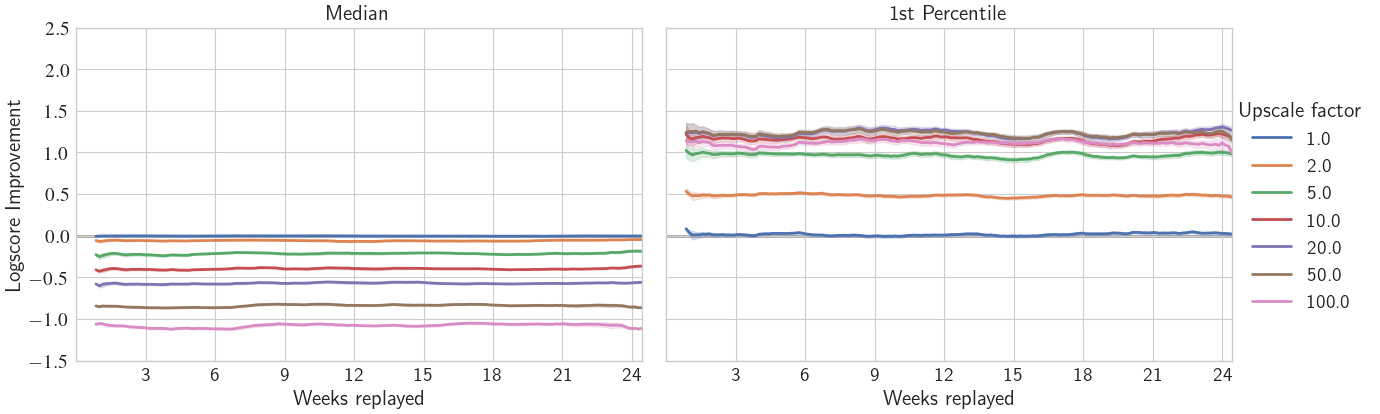

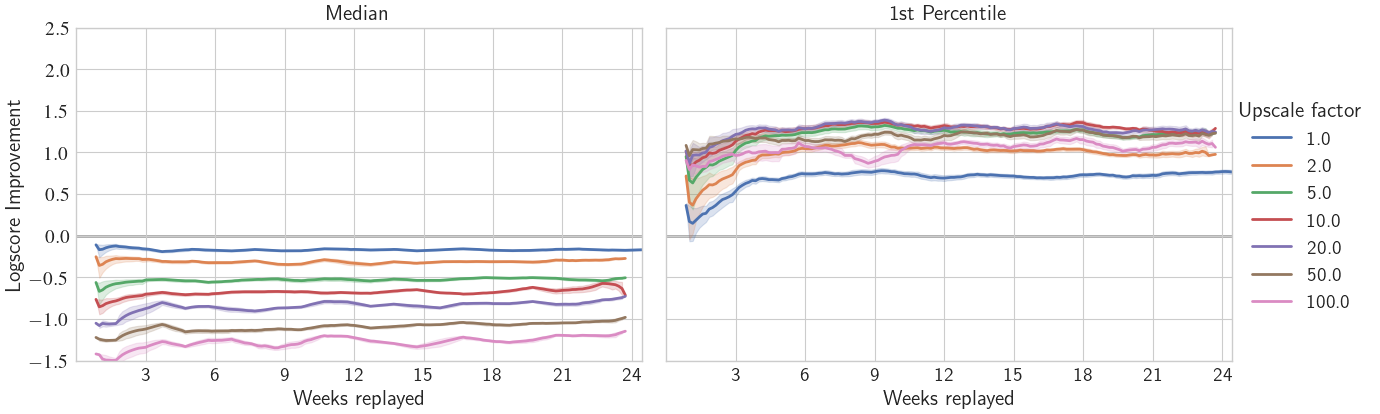

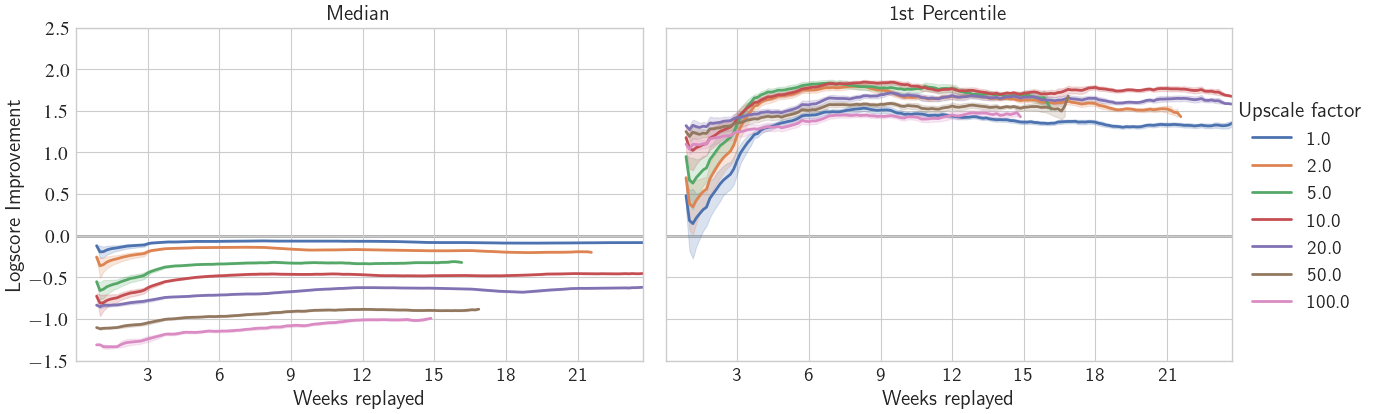

In [8]:
plot_timeseries(
    jtt_comparison.query("comp == 'JTT'"),
    title="Upscale factor",
).set(
    ylim=(-1.5, 2.5)
)
plt.savefig(plotdir / 'jtt_timeline.pdf')
plt.show()

plot_timeseries(
    jtt_comparison.query("comp == 'with Memento'"),
    title="Upscale factor",
).set(
    ylim=(-1.5, 2.5)
)
plt.savefig(plotdir / 'memento_jtt_timeline.pdf')
plt.show()

plot_timeseries(
    jtt_comparison.query("comp == 'and Matchmaker'"),
    title="Upscale factor",
).set(
    ylim=(-1.5, 2.5)
)
plt.savefig(plotdir / 'memento_jtt_matchmaker_timeline.pdf')
plt.show()

# Figure 10: Memento Ensemble vs QBC ensemble

Matchmaker does not care where the ensemble comes from, so we compare using Memento and QBC.
QBC degrades over time, while Memento can reject noise and forget outdated patterns, which helps it retain its performance.

In [ ]:
mm_results, _ = load({
    'combinations/memento-matchmaker': 'Memento',
    'combinations/qbc-matchmaker': 'QBC',
})
# Performance drops after half the time, get summary for steady state.
week15 = "iteration >= 15*7"
display(summarize(mm_results.query(week15)))
display(summarize(mm_results.query(week15), comp="advantage_feb"))

# For the main paper, plot tail timeseries only to highlight degradation.
plot_tail(
    mm_results,
    y=comparison, ylabel="1st P. Logscore Improv.", ylim=(-0.5, 2.5),
    arrow_loc=(0.038, 0.65), arrow_rot=90,
    legend_loc="upper right",
    legend_kwargs=dict(
        title="Matchmaker with:", alignment="left",
        ncols=2, columnspacing=0.8
    ),
)
# Also highlight x=0
ax = plt.gca()
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], "-", zorder=0, color="darkgray", linewidth=2)
ax.set_xlim(xlim)
plt.gcf().savefig(plotdir / "memento_vs_qbc.pdf")
plt.show()

# More plots for the appendix.
plot_timeseries(mm_results, title="Matchmaker with:", ylim=(-3.5, 2.5))
plt.gcf().savefig(plotdir / "memento_vs_qbc_timeline.pdf")
plt.show()

# Alternative retraining decisions

Not shown in paper, we report only the numbers. Compare different decision thresholds.

In [44]:
decision_results, decision_stats = load({
    'comparison/train-decision/coverage/0.05': ' coverage-0.05',
    'comparison/train-decision/coverage/0.10': ' coverage-0.1',
    'comparison/train-decision/coverage/0.20': ' coverage-0.2',
    'comparison/train-decision/loss/0.05': ' loss-0.05',
    'comparison/train-decision/loss/0.10': ' loss-0.1',
    'comparison/train-decision/loss/0.20': ' loss-0.2'
})
summarize(decision_results)

experiment,coverage-0.05,coverage-0.1,coverage-0.2,loss-0.05,loss-0.1,loss-0.2
metric,,,,,,
1st P.,0.723002,0.650649,0.524256,0.758011,0.753438,0.766702
Median,-0.177574,-0.176310,-0.166363,-0.222272,-0.175446,-0.202841


In [45]:
decision_stats_parsed = (
    decision_stats
    # Enumerate retrain events per run.
    .sort_values(by="iteration")
    .groupby(["experiment", "run"], group_keys=False)
    .apply(lambda df: df.assign(n_retrain=df['retrain'].cumsum()))
    # Then, for each retrain event, find "average" iteration when it happens
    # across runs. This is not quite accurate, but if we plot markers per run
    # the plot gets too crowded. This is simpler and gets the idea across.
    .groupby(["experiment", "n_retrain"], as_index=False)
    ['iteration']
    .mean()
    .round(0)  # Match to closest iteration.
    .astype({'iteration': int})
    # Set index so we can join the frame to results
    .assign(plot_marker=True)
    .set_index(['iteration', 'experiment'])
)
decision_results_with_retrain_info = (
    decision_results
    .join(decision_stats_parsed, on=decision_stats_parsed.index.names)
    .fillna({'plot_marker': False})
)

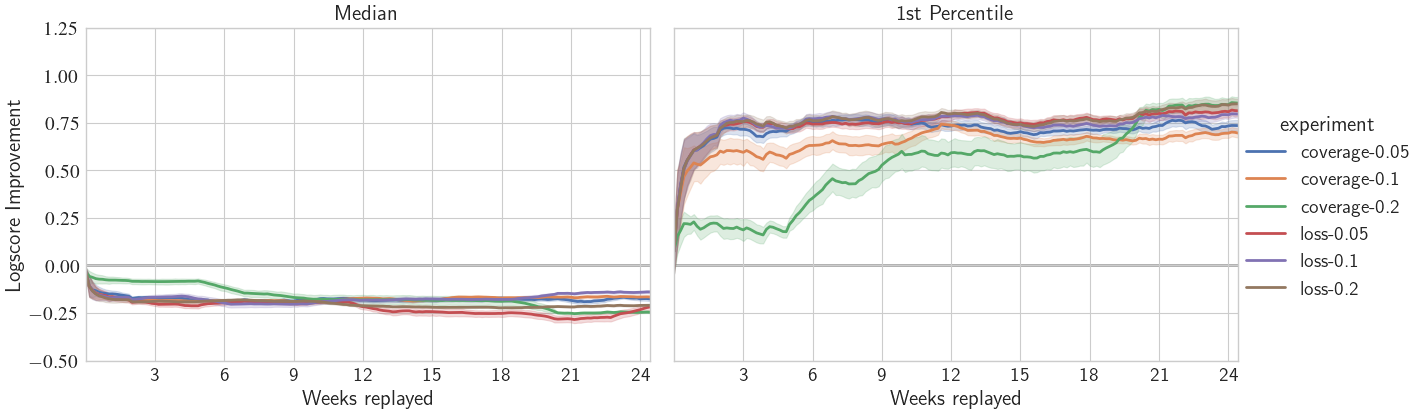

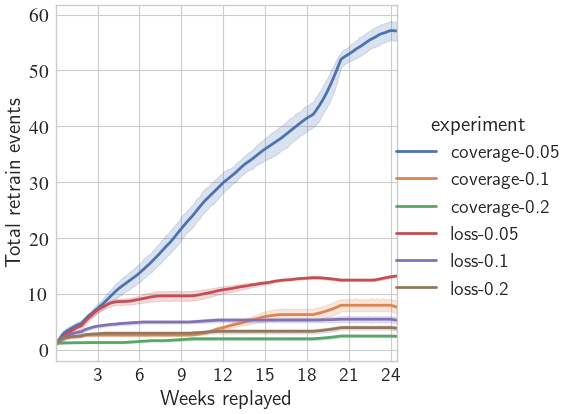

In [46]:
grid = plot_timeseries(decision_results)
plt.savefig(plotdir / 'retrain_decision_metrics.pdf')
plt.show()


retrained = (
    decision_stats
    # Enumerate retrain events per run.
    .sort_values(by="iteration")
    .groupby(["experiment", "run"], group_keys=False)
    .apply(lambda df: df.assign(n_retrain=df['retrain'].cumsum()))
    .reindex(decision_stats.index)
)

last_iter = retrained['iteration'].max()
ticks = np.arange(21, last_iter, 21)
ticklabels = ticks // 7  # #Weeks instead of #Days.

sns.relplot(
    data=sns_rolling(retrained, 14),
    kind='line',
    x='iteration',
    y='n_retrain',
    hue='experiment',
    **eh.plot_utils.opts_square(facet_kws=dict(legend_out=True)),
).set(
    xlim=(0, last_iter),
    xticks=ticks,
    xticklabels=ticklabels,
    xlabel="Weeks replayed",
    ylabel="Total retrain events",
)
plt.savefig(plotdir / 'retrain_decision_events.pdf')
plt.show()